In [1]:
# Install dependencies
%pip install -q langchain langchain-core google-genai python-dotenv langchain_google_genai langgraph


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import os
from typing import TypedDict, List
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from IPython.display import display, Image

from dotenv import load_dotenv

In [8]:
load_dotenv()

True

### Define state, llm

In [9]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str
        
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=os.getenv("GOOGLE_API_KEY"),
)

### Define node functions

In [10]:
def classification_node(state: State):
    """
    Classify the text into one of the following categories:
    - News
    - Research
    - Other
    """
    prompt = ChatPromptTemplate.from_template(
        """
        Classify the following text into one of the categories: News, Blog, Research, or Other.
        Text:{text}
        Category:
    """
    )
    chain = prompt | llm

    content = chain.invoke({"text": state["text"]}).content

    return {"classification": content}


def extraction_node(state: State):
    """
    Extract entities from the text.
    """
    prompt = ChatPromptTemplate.from_template(
        """
        Extract all the entities (Person, Organization, Location) from the following text.
        Provide the result as a comma-separated list.
        Text:{text}
        Entities:
    """
    )

    chain = prompt | llm

    content = chain.invoke({"text": state["text"]}).content.strip().split(", ")

    return {"entities": content}


def summary_node(state: State):
    """
    Generate a summary of the text.
    """
    prompt = ChatPromptTemplate.from_template(
        """
        Generate a summary of the following text.
        Text:{text}
        Summary:
    """
    )

    chain = prompt | llm

    content = chain.invoke({"text": state["text"]}).content

    return {"summary": content}

### Create workflow

In [12]:
workflow = StateGraph(State)

# Add nodes
workflow.add_node("classification_node", classification_node)
workflow.add_node("extraction_node", extraction_node)
workflow.add_node("summary_node", summary_node)

# Add edges
workflow.set_entry_point("classification_node")
workflow.add_edge("classification_node", "extraction_node")
workflow.add_edge("extraction_node", "summary_node")
workflow.add_edge("summary_node", END)

# Build
graph = workflow.compile()

### Display graph

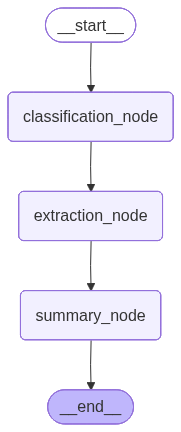

In [14]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [16]:
sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""

state_input = {"text": sample_text}
result = graph.invoke(state_input)

print("Classification:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classification: News

Entities: ['OpenAI', 'GPT-4', 'GPT-3']

Summary: OpenAI has announced GPT-4, a more efficient, scalable, and safer large multimodal model designed to perform at a human level on professional benchmarks. It will be released to the public for research and development in the coming months.
